<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Part 1: Dataset and Image Augmentation


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np
from IPython.display import display, clear_output

## Background

Connectify.ai is a Singaporean tech start up that focuses on providing AI solutions to the healthcare industry. One of the challenges that they are trying to tackle is developing a mobile application that helps monitor the food intakes for people with diabetes. Part of the monitoring and recommendation process includes food journalling which involves the users entering the food eaten at each meal during the day. This manual process can become cumbersome and thus alternatives such as having the users take pictures of their food and automatically identifying the name of the food is being considered.

With the collaboration with Conenctify.ai, I will be developing classifier models using Convolutional Neural Networks that can be used to identify the name of some of the more popular food in SEA. This can eventually be used in the mobile application to make the food journalling process more user friendly.

## Datasets

##### Training & Validation Sets
The training and validation food images are taken from a well known Food 101 dataset which can be downloaded from [Kaggle](https://www.kaggle.com/dansbecker/food-101). The original dataset contains 101 categories of food with 1000 images in each category. However, since this application will be mostly focused in SEA, we decided that at this stage, we only be using the food category that are more popular in SEA. This reduced the number of categories to 29 resulting in 29000 food images in total (before image augmentation).

##### Testing Set
The images in the testing set were webscraped from search engines such as Google and Bing. This testing set includes 580 images in total, each with 20 images.


***These images across the training, validation and testing sets are above 256x256 in resolution.***

#### Example Images

In [97]:
train_path = "./datasets/datasets_v2/train"
food_folders = glob.glob('./datasets/datasets_v2/train/*')
food_labels = [food.split('\\')[-1] for food in food_folders]
food_labels = sorted(food_labels)

In [98]:
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path,target_size=(299,299),classes=food_labels,batch_size=15,seed=1)

Found 76345 images belonging to 29 classes.


In [99]:
def plotImages(images_arr,label):
    fig, axes = plt.subplots(3,5,figsize=(16,9))
    axes = axes.flatten()
    for imag,lb, ax in zip(images_arr,label,axes):
        food_name = food_labels[np.argmax(lb)]
        ax.imshow(imag.astype('uint8'))
        ax.set_title(food_name)
        ax.axis('off')
    plt.tight_layout()
    #plt.show()

In [100]:
imgs, labels = next(train_batches)

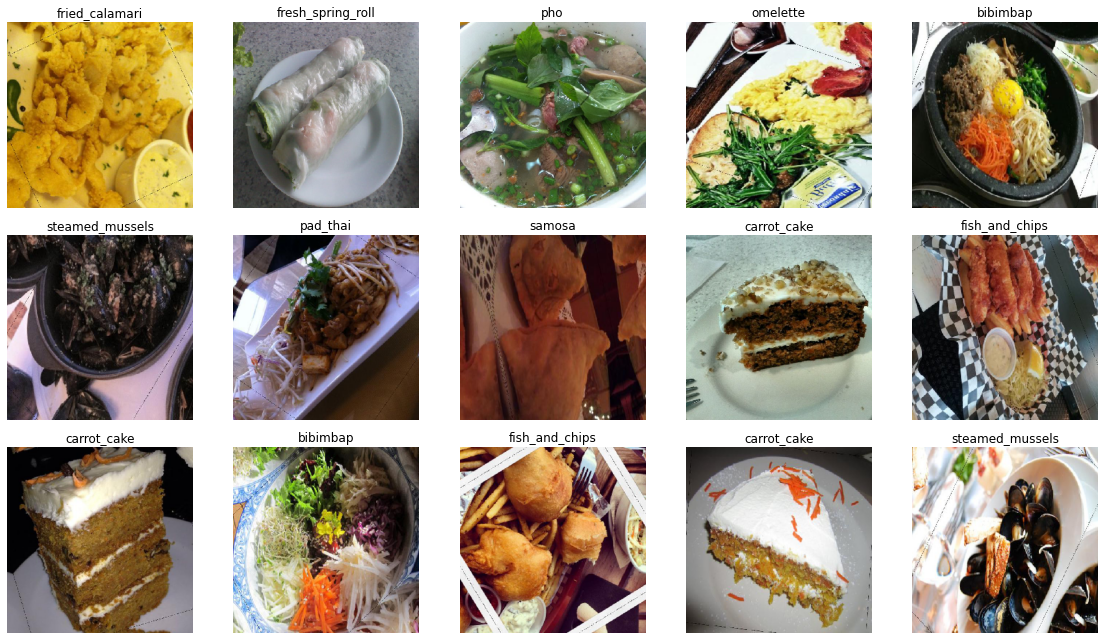

In [101]:
plotImages(imgs, labels);

### Image Label verification

The images in the datasets do not necessarily correspond to the labels given in the dataset with some of the images being completely irrelevant to the labels. These are manually reviewed and removed while some images are reassigned to the correct label.

In [57]:
food_folders = glob.glob("./datasets\selected - backup (original size)/*")
food_labels = [food.split('\\')[-1] for food in food_folders]


miscfood_files = glob.glob("./datasets/mislabelled_examples/*")
miscfood_labels = [food.split('\\')[-1] for food in miscfood_files]



for f in miscfood_labels:
    for idx,f2 in enumerate(food_folders):
        #print(f2.replace('\\','/')+'/'+f)
        if path.exists(f2.replace('\\','/')+'/'+f):
            print(f'{food_labels[idx]}: {f}')


samosa: 1478597.jpg
chicken_curry: 1753210.jpg
ramen: 1867478.jpg
caesar_salad: 1994771.jpg
miso_soup: 2033734.jpg
spring_rolls: 2232700.jpg
hummus: 23512.jpg
pho: 2399877.jpg
pad_thai: 2614597.jpg
ramen: 2838872.jpg
peking_duck: 2903881.jpg
spring_rolls: 2962770.jpg
miso_soup: 3766366.jpg
peking_duck: 388951.jpg
carrot_cake: 688689.jpg
chicken_curry: 789540.jpg
carrot_cake: 903658.jpg


#### Examples of irrelevant images


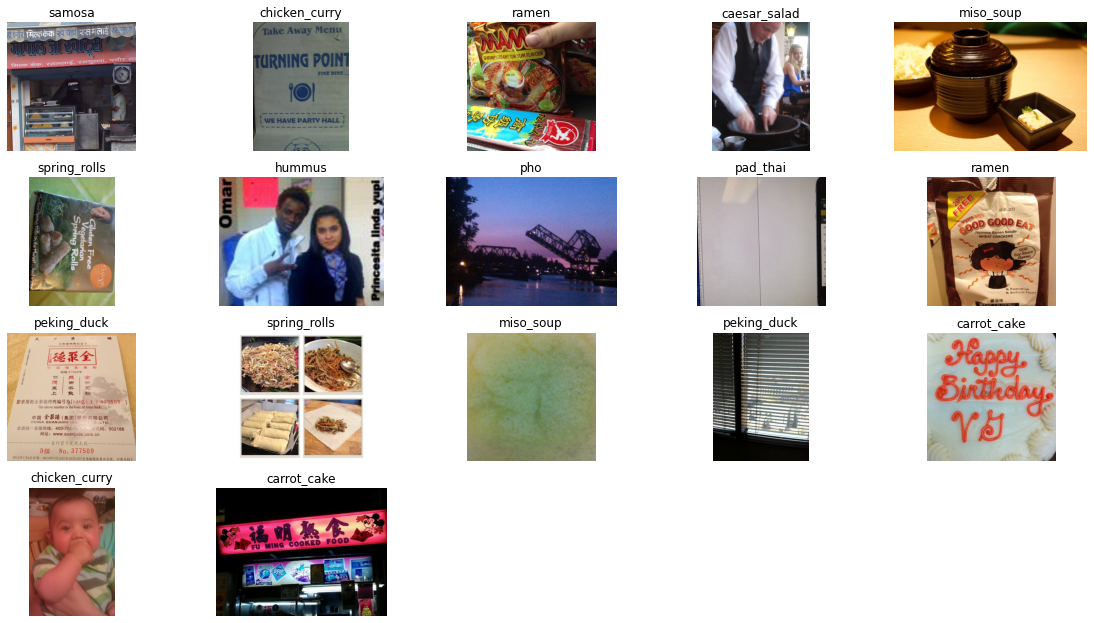

In [59]:
miscfood_files = glob.glob("./datasets/mislabelled_examples/*")

misc_labels = ['samosa',
'chicken_curry',
'ramen',
'caesar_salad',
'miso_soup',
'spring_rolls',
'hummus',
'pho',
'pad_thai',
'ramen',
'peking_duck',
'spring_rolls',
'miso_soup',
'peking_duck',
'carrot_cake',
'chicken_curry',
'carrot_cake']

plt.figure(figsize=(16, 9))
for i in range(len(miscfood_files)):
    mislab_im = tf.keras.preprocessing.image.load_img(miscfood_files[i])
    mislab_im = tf.keras.preprocessing.image.img_to_array(mislab_im)
    ax = plt.subplot(4,5, i + 1)

    #img_np = tf.reshape(augmented_image,[512,384,3]).numpy()
    im = Image.fromarray((mislab_im * 255).astype(np.uint8))
    ax.set_title(misc_labels[i])
    plt.tight_layout()
    plt.imshow(mislab_im / 255)
    
    plt.axis('off')

### Image Data Augmentation

Data augmentation is a technique to artificially create new training data from existing training data.  This involves creating transformed versions of images in the training dataset that belong to the same class as the original image. This was done in order to expand the training sets and to ensure that the model will be more robust when it comes to classifying food images taken from different angles and orientations. Since the original data contains a good number of images per category with each having images taken from different angles/orientations, it was decided the image augmentation will be performed only twice per image given the limited project timeframe as having larger a training set will impact the model training speed. 

***With augmentation, each category now has ~3000 images with a grand total of ~87000 images in the dataset. This dataset was then split into training and validation set at a ratio of 9:1.***

In this project, the transformations performed include:
- (1) Randomly flipping the images on the horizontal axis
- (2) Randomly rotating the images clockwise and anti-clockwise
- (3) Randomly shifting/translating the image left and right

In [105]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15,0.15)
    
])

In [108]:
first_image = tf.keras.preprocessing.image.load_img('./datasets/datasets_v2/train/club_sandwich/2415.jpg')
first_image = tf.keras.preprocessing.image.img_to_array(first_image)
first_image.shape

(512, 384, 3)

#### The images below show some examples of the augmented images...

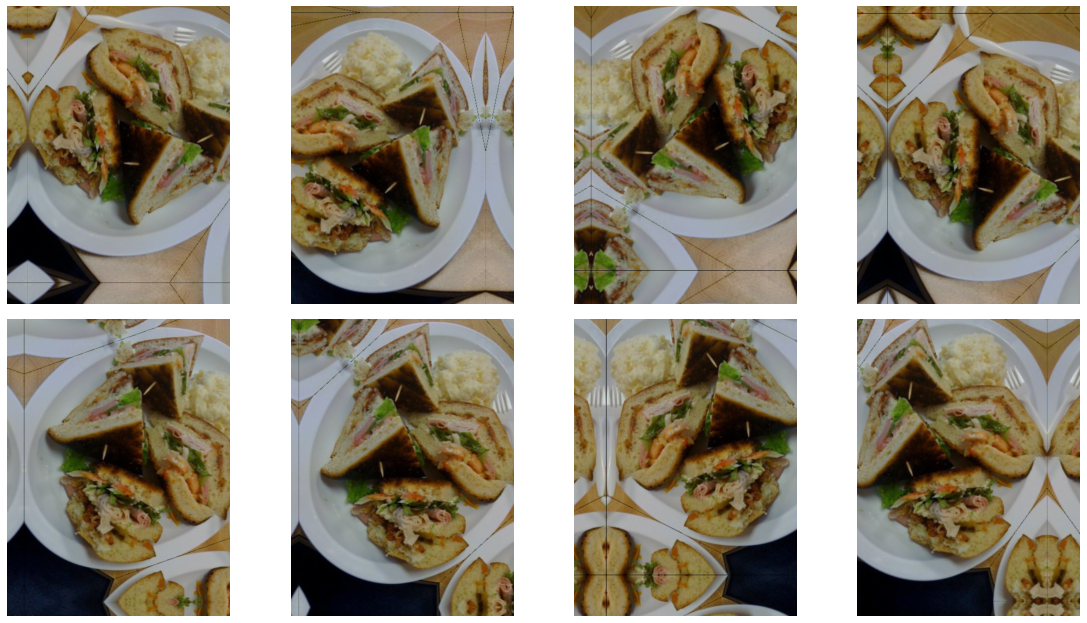

In [119]:
plt.figure(figsize=(16, 9))
for i in range(8):
    ax = plt.subplot(2,4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    img_np = tf.reshape(augmented_image,[512,384,3]).numpy()
    im = Image.fromarray((img_np * 255).astype(np.uint8))
    im.save(f"test{str(i)}.jpg")
    plt.tight_layout()
    plt.imshow(augmented_image[0] / 255)
    
    plt.axis('off')

### Creating Augmented Images

In [27]:
food_folders = glob.glob("./datasets/datasets_v2/*")
counter = 0
for idx,folder in enumerate(food_folders):
    counter = 0
    f_images = glob.glob(folder+'/*')
    if idx+1 != 10:
        continue
    for idx2,im in enumerate(f_images):
        current_image = plt.imread(im)
        path = ((im.split('.'))[1]).split('\\')

        for i in range(7):
            augmented_image = data_augmentation(tf.expand_dims(current_image, 0))
            img_np = tf.reshape(augmented_image,list(current_image.shape)).numpy()
            final_im = Image.fromarray(img_np.astype(np.uint8)).convert('RGB')
            path_a = f'.{path[0]}/{path[1]}/Aug{counter}.jpg'
            final_im.save(path_a)
            counter += 1
        
        #print(f'{idx+1}/{len(food_folders)} ==> {round((idx2+1)/1000*100,1)}%', end='\r')
        

In [29]:
food_folders = glob.glob("./datasets/datasets_v2/train/*")
num_pics = 0
for folder in food_folders:
    f_images = glob.glob(folder+'/*')
    num_pics += len(f_images)
num_pics

85047